In [1]:
# %tensorflow_version 2.x
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# GD = "/content/drive/My Drive/DeepLearning/"
# import sys
# sys.path.append(GD + 'code/')

In [2]:
import numpy as np
import scipy as sp

import os

import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow.keras as keras
import tensorflow as tf

import pickle
import random

from sklearn.model_selection import KFold
from scipy.sparse import block_diag as sparse_block_diag
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

from utils.labels_preprocessing import load_labels
from utils.load_synced_inputs import load_inputs, load_fmri
from utils.load_graphs import load_graph
from cnn_graph.resnetgraph import cgcnn
from cnn_graph import graph
import tensorflow.keras.backend as K
from new_utils import utils

In [3]:
tf.test.is_gpu_available()

True

In [4]:
# fmri preprocess

fmri_subcortical_dir = '../Subcortical_fmri'
# fmri_subcortical_dir = 'C:/Users/YuNan/Downloads/auto_encoder_try/data/Subcortical_fmri'
assert len(os.listdir(fmri_subcortical_dir)) == len(set(os.listdir(fmri_subcortical_dir)))


In [5]:
home = f"{os.getcwd()}/.."

graphs_dir = "../Graphs/"            # directory containing necessary graphs
# print(graphs_dir)
# cortical_dir = f"{home}/Cortical"         # cortical node data for each subject
# subcortical_dir = f"{home}/SubCortical"   # subcortical node data for each subject
# cortical_dir = 'C:/Users/YuNan/Downloads/auto_encoder_try/data/Cortex'
subcortical_dir = '../Subcortical'

# for scan in os.listdir(cortical_dir):
#     print (f"{scan[:-11]}_Subcortical")
#     assert os.path.isfile(f"{subcortical_dir}/{scan[:-11]}_Subcortical.mat")

assert len(os.listdir(subcortical_dir)) == len(set(os.listdir(subcortical_dir)))

# L = {'cortical': load_graph(graphs_folder=graphs_dir, prefix='M_w')}
# # print(L)
# L['cortical'] = [graph.laplacian(A) for A in L['cortical']]
# # print(L['cortical'])

L = {'subcortical' : load_graph(graphs_folder=graphs_dir, prefix='M_sc_w')}
L['subcortical'] = [graph.laplacian(A) for A in L['subcortical']]
print(L['subcortical'])

# # Block Diagonalize the Cortical & Subcortical Laplacians at Each Level of Coarsening
new_L = []
for A in zip(L[f"subcortical"]):
    new_L.append( sparse_block_diag((A)) )
L = new_L
# print(L)
del new_L

[<14848x14848 sparse matrix of type '<class 'numpy.float32'>'
	with 103768 stored elements in Compressed Sparse Row format>, <7424x7424 sparse matrix of type '<class 'numpy.float32'>'
	with 51800 stored elements in Compressed Sparse Row format>, <3712x3712 sparse matrix of type '<class 'numpy.float32'>'
	with 25816 stored elements in Compressed Sparse Row format>, <1856x1856 sparse matrix of type '<class 'numpy.float32'>'
	with 12824 stored elements in Compressed Sparse Row format>, <928x928 sparse matrix of type '<class 'numpy.float32'>'
	with 6328 stored elements in Compressed Sparse Row format>, <464x464 sparse matrix of type '<class 'numpy.float32'>'
	with 3080 stored elements in Compressed Sparse Row format>, <232x232 sparse matrix of type '<class 'numpy.float32'>'
	with 1456 stored elements in Compressed Sparse Row format>, <116x116 sparse matrix of type '<class 'numpy.float32'>'
	with 648 stored elements in Compressed Sparse Row format>]


In [6]:
L

[<14848x14848 sparse matrix of type '<class 'numpy.float32'>'
 	with 103768 stored elements in Compressed Sparse Row format>,
 <7424x7424 sparse matrix of type '<class 'numpy.float32'>'
 	with 51800 stored elements in Compressed Sparse Row format>,
 <3712x3712 sparse matrix of type '<class 'numpy.float32'>'
 	with 25816 stored elements in Compressed Sparse Row format>,
 <1856x1856 sparse matrix of type '<class 'numpy.float32'>'
 	with 12824 stored elements in Compressed Sparse Row format>,
 <928x928 sparse matrix of type '<class 'numpy.float32'>'
 	with 6328 stored elements in Compressed Sparse Row format>,
 <464x464 sparse matrix of type '<class 'numpy.float32'>'
 	with 3080 stored elements in Compressed Sparse Row format>,
 <232x232 sparse matrix of type '<class 'numpy.float32'>'
 	with 1456 stored elements in Compressed Sparse Row format>,
 <116x116 sparse matrix of type '<class 'numpy.float32'>'
 	with 648 stored elements in Compressed Sparse Row format>]

In [7]:
# load the dataset 
import pandas as pd
Path = '../data.csv'
df = pd.read_csv(Path)
filenames = df['Subject'].astype('str').to_numpy()
# print(filenames)
filenames2 = (filenames + '_Subcortical' +'.mat').tolist()
# print(filenames2)
df

,Subject
0,1000102_20252_2_0
1,1000710_20252_2_0
2,1000742_20252_2_0
3,1001275_20252_2_0
4,1001693_20252_2_0
...,...
190,1030712_20252_2_0
191,1030841_20252_2_0
192,1030960_20252_2_0
193,1031057_20252_2_0


In [10]:
# fmri 
graph_type = {'subcortical':{'path':fmri_subcortical_dir, 
                             'halves':False}
}


X = load_fmri(graph_type=graph_type, filenames = filenames2)

sub_graphs = list(graph_type.keys())
assert sub_graphs == ['subcortical']

Subcortical	(Samples, Nodes, Feat.):	(195, 14848, 490)


In [11]:
# try
X_try = {}
X_try['subcortical'] = X['subcortical'][:100,:,10:]
del X
# X_try['subcortical'] = X['subcortical'][:,:,0:200]
X_try['subcortical'].shape
X = X_try
del X_try

In [12]:
X['subcortical'].shape

(100, 14848, 480)

In [13]:
# fmri block
from scipy.linalg import block_diag
from sklearn.utils import resample

all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
# X_max = np.max(all_nodes)
# X_min = np.min(all_nodes)
X_mean = np.mean(all_nodes)
X_std = np.std(all_nodes)

print(X_mean, X_std)

for sub in sub_graphs:
    X[sub] = (X[sub] - X_mean) / X_std
#     X[sub] *= 2
#     X[sub] -= 1
del all_nodes   
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
del all_nodes

new_X = []
for A in zip(X[f"subcortical"]):
    new_X.append(np.concatenate((A), axis = 0))
    
X = np.concatenate([np.expand_dims(i, axis=0) for i in new_X], axis=0).astype('float32')
X.shape


0.019178856 40.186802


(100, 14848, 480)

In [14]:
# split with time point
new_X = []
# bb.T.reshape()
for i in range(X.shape[0]):
    new_X.append(X[i,:,:].T)
new_XX = np.concatenate([np.expand_dims(i, axis=0) for i in new_X], axis=0).astype('float32')
X_re = np.reshape(new_XX, (X.shape[0]* X.shape[2], X.shape[1], 1))
del X
X_re.shape

(48000, 14848, 1)

In [15]:
del new_XX
X_re2 = np.reshape(X_re, (8000,6,14848,1))

In [16]:
X_re2.shape

(8000, 6, 14848, 1)

In [17]:
# import matplotlib.pyplot as plt
# fig = X_re2[10, 0, :, :]
# plt.plot(fig)

In [18]:
# fig = X_re2[10,9, :, :]
# plt.plot(fig)

In [19]:

X_train, X_test = X_re2[:8*800,:,:,:], X_re2[8*800:,:,:,:]
# X_ttest = X_re[39000:,:,:]
del X_re
del X_re2
print(X_train.shape, X_test.shape)
batch_size = 4

train_generator = utils.DataGenerator2(X_train, 
                                      batch_size = batch_size, 
                                      shuffle=True, 
                                      force_balance=False, 
                                      do_augmentation = False, 
#                                       tta=10, 
#                                       aug_params=aug_training,
                                      auto_encoder=True)
test_generator  = utils.DataGenerator2(X_test,  
                                      batch_size = batch_size, 
                                      shuffle=False, 
                                      force_balance=False, 
                                      do_augmentation = False, 
#                                       tta=10, 
#                                       aug_params=aug_testing,
                                      auto_encoder=True)

# ttest_generator  = utils.DataGenerator(X_ttest,  
#                                       batch_size = 1, 
#                                       shuffle=False, 
#                                       force_balance=False, 
#                                       do_augmentation = False, 
# #                                       tta=10, 
# #                                       aug_params=aug_testing,
#                                       auto_encoder=True)

(6400, 6, 14848, 1) (1600, 6, 14848, 1)


In [20]:
print(len(train_generator))
len(test_generator)

1600


400

## Architecture of the network

In [23]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Dense, GRU, GlobalAveragePooling1D, 
    GlobalAveragePooling2D, TimeDistributed, 
    concatenate, Masking, Bidirectional
)
encoder_inputs = keras.Input(shape=(6,14848,1))
latent_dim = 256
Depth = 7
n_filter = 32

for B in range(Depth):
    for F in range(2):
        if B == 0 and F == 0:
            x1 = TimeDistributed(utils.ChebLayer(L[B],3,n_filter,use_bias=True,kernel_regularizer=keras.regularizers.l2(5e-5)))(encoder_inputs)
        else:
            x1 = TimeDistributed(utils.ChebLayer(L[B],3,n_filter,use_bias=True,kernel_regularizer=keras.regularizers.l2(5e-5)))(x1)
            x1 = TimeDistributed(keras.layers.BatchNormalization())(x1)
            x1 = TimeDistributed(keras.layers.Activation('elu'))(x1)
            x1 = TimeDistributed(utils.ChebLayer(L[B],3,n_filter,use_bias=False,kernel_regularizer=keras.regularizers.l2(5e-5)))(x1)
            x1 = TimeDistributed(keras.layers.BatchNormalization())(x1)
            x1 = TimeDistributed(keras.layers.Activation('elu'))(x1)
    x1 = TimeDistributed(keras.layers.MaxPooling1D(2))(x1)
x =  TimeDistributed(layers.Flatten())(x1)
        
x = LSTM(units=256, activation='elu', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, return_sequences = True)(x)
z_mean = TimeDistributed(layers.Dense(latent_dim, name = 'z_mean'))(x)
z_log_var = TimeDistributed(layers.Dense(latent_dim, name = 'z_log_var'))(x)
#         print(z_mean.shape)
#         print(z_log_var[2][2])
        
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.) 
    return z_mean + K.exp(z_log_var/2)*epsilon 
z = layers.Lambda(sampling, name='encoder_output')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Decoder ResNet Blocks
latent_inputs = keras.Input(shape=(6,latent_dim,))
x = TimeDistributed(layers.Dense(3712))(latent_inputs)
x = TimeDistributed(layers.Reshape((116, 32)))(x)
# print(x.shape)
for B in range(Depth):
    for F in range(2):
        #print(L[Depth - B].shape)
        if B == 0 and F == 0:
            x1 = TimeDistributed(utils.ChebLayer(L[Depth - B],3,n_filter,use_bias=False,kernel_regularizer=keras.regularizers.l2(5e-5)))(x)
        else:
            x1 = TimeDistributed(utils.ChebLayer(L[Depth - B],3,n_filter,use_bias=False,kernel_regularizer=keras.regularizers.l2(5e-5)))(x1)
        x1 = TimeDistributed(keras.layers.BatchNormalization())(x1)
        x1 = TimeDistributed(keras.layers.Activation('elu'))(x1)
        x1 = TimeDistributed(utils.ChebLayer(L[Depth - B],3,n_filter,use_bias=False,kernel_regularizer=keras.regularizers.l2(5e-5)))(x1)
        x1 = TimeDistributed(keras.layers.BatchNormalization())(x1)
        x1 = TimeDistributed(keras.layers.Activation('elu'))(x1)
    x1 = TimeDistributed(keras.layers.UpSampling1D(size=2))(x1)
decoder_outputs = TimeDistributed(utils.ChebLayer(L[0],3,1,use_bias=False,kernel_regularizer=keras.regularizers.l2(5e-5)))(x1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Instantiate VAE
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae         = Model(encoder_inputs, vae_outputs, name='vae')
vae.summary()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6, 14848, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_183 (TimeDistr (None, 6, 14848, 32) 128         input_3[0][0]                    
__________________________________________________________________________________________________
time_distributed_184 (TimeDistr (None, 6, 14848, 32) 3104        time_distributed_183[0][0]       
__________________________________________________________________________________________________
time_distributed_185 (TimeDistr (None, 6, 14848, 32) 128         time_distributed_184[0][0]       
____________________________________________________________________________________________

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 6, 256)]          0         
_________________________________________________________________
time_distributed_272 (TimeDi (None, 6, 3712)           953984    
_________________________________________________________________
time_distributed_273 (TimeDi (None, 6, 116, 32)        0         
_________________________________________________________________
time_distributed_274 (TimeDi (None, 6, 116, 32)        3072      
_________________________________________________________________
time_distributed_275 (TimeDi (None, 6, 116, 32)        128       
_________________________________________________________________
time_distributed_276 (TimeDi (None, 6, 116, 32)        0         
_________________________________________________________________
time_distributed_277 (TimeDi (None, 6, 116, 32)        3072

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6, 14848, 1)]     0         
_________________________________________________________________
encoder (Model)              [(None, 6, 256), (None, 6 4279584   
_________________________________________________________________
decoder (Model)              (None, 6, 14848, 1)       1043680   
Total params: 5,323,264
Trainable params: 5,319,808
Non-trainable params: 3,456
_________________________________________________________________


In [25]:
LEARNING_RATE = 0.0002
LOSS_FACTOR = 500

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = keras.optimizers.Adam(lr = LEARNING_RATE)

vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', 
                   verbose=1, 
                   patience=8, 
                   min_delta=0.0001, 
                   mode='min')
mc = ModelCheckpoint('../lstm_vae.hdf5', 
                     monitor='val_loss', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss',
                        mode='min',
                        factor=0.1,
                        patience=8)

In [1]:
epochs = 100
history = vae.fit(train_generator, validation_data=test_generator, epochs = epochs, use_multiprocessing=False, callbacks = [es, mc,rlr])

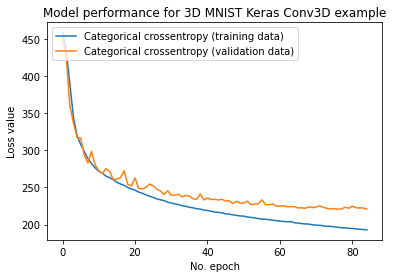

In [28]:
# Plot history: Categorical crossentropy & Accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
# plt.plot(history.history['acc'], label='Accuracy (training data)')
# plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()